# Structural cereal model

In [1]:
#| echo: false

# Ignore warning about depreciated modules
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
#| echo: false

# Import path of model
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, './src')

In [3]:
#| echo: false

# Enable interactive plotting
%matplotlib ipympl

In this section, we define a static structural model for cereals.  
The paragraphs are organized so that it is easy to see how the model is built and how we can play with parameters.  

Some 3D plots are interactive, don't hesitate to rotate them.

## Create a parametric leaf

The leaf blade is represented as a surface.  
A parametric leaf is here defined by sample points (here 12), described by two sets of coordinates:  
- $(x,y)$: coordinates for the midrib in a vertical plane, give the curvature of the leaf;  
- $(s,r)$: curviliear abcissa (i.e. length along midrib) and relative length-dependent leaf width.

Note that $s$ can be expressed as a function of $x$ and $y$, at point $p \neq 0$, as follows: $ s_p(x,y) = \sqrt{(x_p-x_{p-1})^2+(y_p-y_{p-1})^2} $.  

The origin represents the leaf base.  

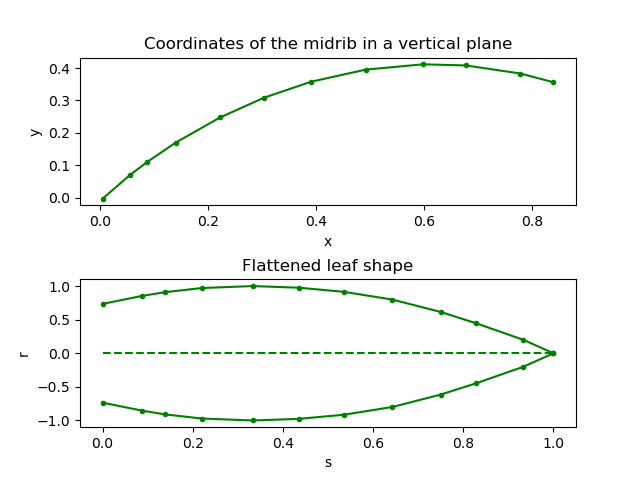

In [4]:
## Imports

# from installed packages
import numpy as np
import matplotlib.pyplot as plt
from heapq import *
from scipy.interpolate import splprep, splev
from scipy.integrate import simps, trapz
from openalea.plantgl.all import Vector3

# from ./src
from cereals_leaf import leaf_shape_perez, sr_prevot, parametric_leaf
# or
# from simple_maize import leaf_shape_perez, sr_prevot, parametric_leaf
# from fitting import leaf_shape_perez
from generator import curvilinear_abscisse
from fitting import fit2, fit3, simplify
from simplification import distance, cost

## Code for generating a parametric leaf for a cereal 
pl=parametric_leaf(nb_segment=10, insertion_angle=40, scurv=0.7, curvature=70, alpha=-2.3)

fig, (ax1, ax2) = plt.subplots(nrows=2) 
# fig.suptitle('Parametric leaf')

ax1.plot(pl[0], pl[1], '.-', c="green")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title("Coordinates of the midrib in a vertical plane")

ax2.plot(pl[2], pl[3], '.-', c="green")
ax2.plot(pl[2], -pl[3], '.-', c="green")
ax2.plot(np.arange(0,1.1,0.1), np.zeros(11), c="green", ls="dashed")
ax2.set_xlabel('s')
ax2.set_ylabel('r')
ax2.set_title("Flattened leaf shape")

plt.subplots_adjust(hspace=0.5)

plt.show()

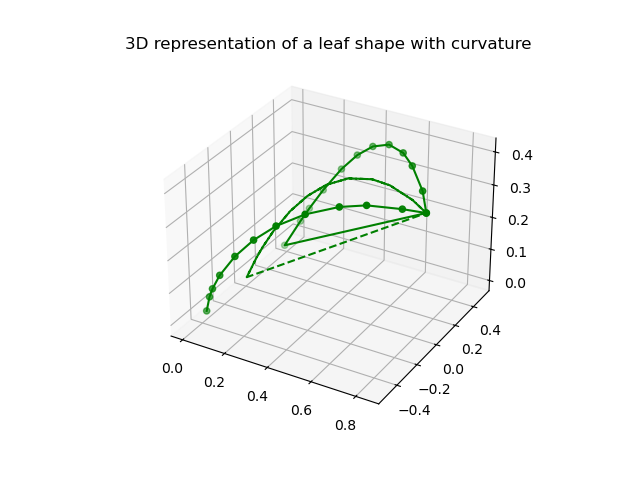

In [5]:
## Imports

# from installed packages
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp2d
import matplotlib.tri as mtri

# from./src
from fitting import leaf_to_mesh_2d

## Code for representing the parametric leaf in 3D (ignore excess lines)
x=pl[0]
y=pl[1]
s=pl[2]
r=pl[3]

pts,ind=leaf_to_mesh_2d(x, y, r)

xs=[pt[0] for pt in pts]
ys=[pt[1] for pt in pts]
zs=[pt[2] for pt in pts]
    
X,Y=np.meshgrid(xs, ys)

tri=mtri.Triangulation(xs, ys)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(xs,ys,zs,c="green")
ax.plot(xs,ys,zs,c="green")
ax.plot(xs,np.zeros(len(ys)),zs,c="green",ls="dashed")
ax.set_title("3D representation of a leaf shape with curvature")
plt.show()

Please ignore excess straight lines.

## Generate leaf azimuth series

Leaves grow around an axis with a given phyllotaxy, represented here as an angle from leaf to leaf (e.g. spiral with a given angle or alternate distichous = $180^o$).  

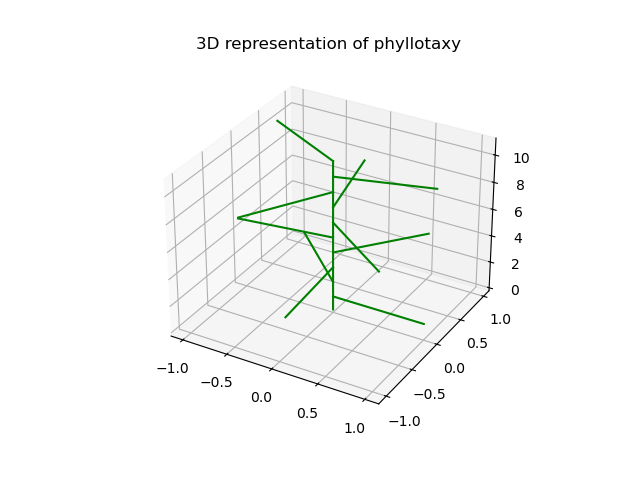

In [6]:
## Imports

# from installed packages 
# from itertools import cycle

# from ./src
from plant_design import leaf_azimuth

## Code for generating leaf azimuths series for a given phyllotaxy
nb_phy=10
phyllotactic_angle=137
spiral=True
phyllotactic_deviation=0
plant_orientation=0

la=leaf_azimuth(size=nb_phy, 
                phyllotactic_angle=phyllotactic_angle, 
                phyllotactic_deviation=phyllotactic_deviation, 
                plant_orientation=plant_orientation, 
                spiral=spiral)

x=np.cos(la*np.pi/180)
y=np.sin(la*np.pi/180)
z=np.linspace(1,len(la)+1,len(la))

fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
for i,a in enumerate(la):
    ax.plot(np.linspace(0,x[i],2), np.linspace(0,y[i],2), [z[i],z[i]], c="green")
ax.plot([0,0], [0,0], [0,z[-1]], c="green")

ax.set_title("3D representation of phyllotaxy")

plt.show()

## Manage internode lengths

Internodes on an axis have varying lengths. The repartition of their lengths along the axis can be approximated with a geometric model.

In [7]:
def geometric_dist(height, nb_phy, q=1):
    """ returns distances between individual leaves along a geometric model """

    if q==1:
        u0=float(height)/nb_phy
    else:
        u0=height*(1.-q)/(1.-q**(nb_phy+1))

    return [u0*q**i for i in range(nb_phy)]

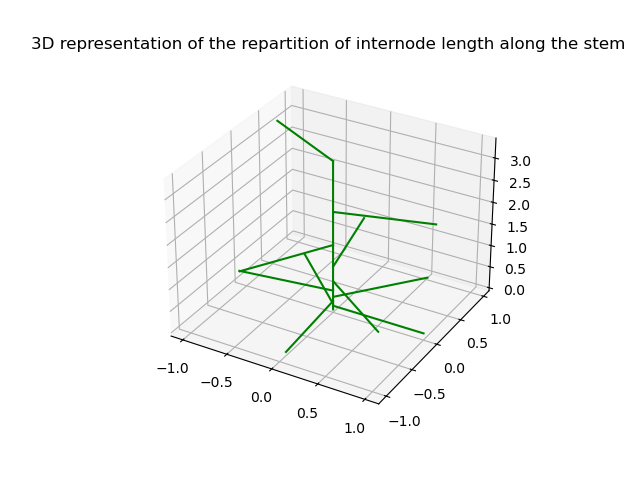

In [8]:
## Code for applying lengths to internodes according to a geometric model
plant_height=15
q=1.5

x=np.cos(la*np.pi/180)
y=np.sin(la*np.pi/180)
z=geometric_dist(height=plant_height, 
                   nb_phy=nb_phy, 
                   q=q)

fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
for i,a in enumerate(la):
    ax.plot(np.linspace(0,x[i],2), np.linspace(0,y[i],2), [z[i],z[i]], c="green")
ax.plot([0,0], [0,0], [0,z[-1]], c="green")

ax.set_title("3D representation of the repartition of internode length along the stem")

plt.show()

## Manage leaf lengths as a function of height

Leaves that grow on an axis have varying lengths. The repartition of their lengths along the axis can be approximated with a bell shaped model.

In [9]:
def bell_shaped_dist(max_leaf_length, nb_phy, rmax=.7, skew=0.15):
    """ returns leaf area of individual leaves along bell shaped model """

    k = -np.log(skew) * rmax
    r = np.linspace(1. / nb_phy, 1, nb_phy)
    relative_length = np.exp(-k / rmax * (2 * (r - rmax) ** 2 + (r - rmax) ** 3))
    # leaf_length = relative_length / relative_length.sum() * max_leaf_length
    leaf_length = relative_length * max_leaf_length
    return leaf_length.tolist()

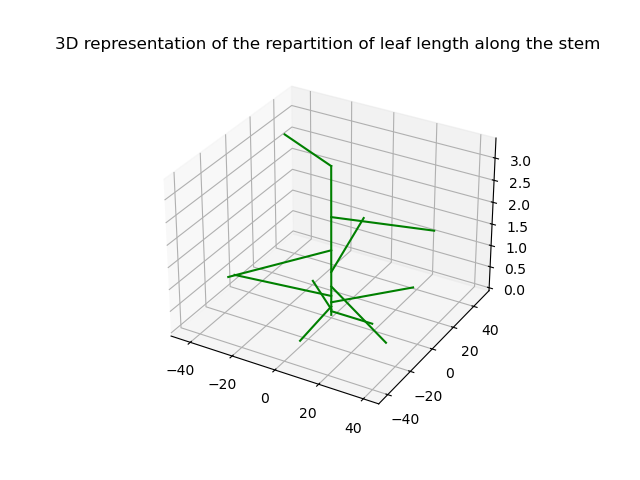

In [10]:
## Code for applying lengths to leaves according to a bell shaped model
max_leaf_length=50

bsd=bell_shaped_dist(max_leaf_length=max_leaf_length, 
                     nb_phy=nb_phy, 
                     rmax=.7, 
                     skew=0.15)

x=np.cos(la*np.pi/180)*bsd
y=np.sin(la*np.pi/180)*bsd
z=geometric_dist(height=plant_height, 
                   nb_phy=nb_phy, 
                   q=q)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
for i,a in enumerate(la):
    ax.plot(np.linspace(0,x[i],2), np.linspace(0,y[i],2), [z[i],z[i]], c="green")
ax.plot([0,0], [0,0], [0,z[-1]], c="green")

ax.set_title("3D representation of the repartition of leaf length along the stem")

plt.show()

## Arrange a leaf to be placed along a stem with a given inclination.

A leaf must undergo a translation to be placed against the surface of the stem (tangent to it), and a rotation to be tilted like the stem (inclination = 1 if main stem).

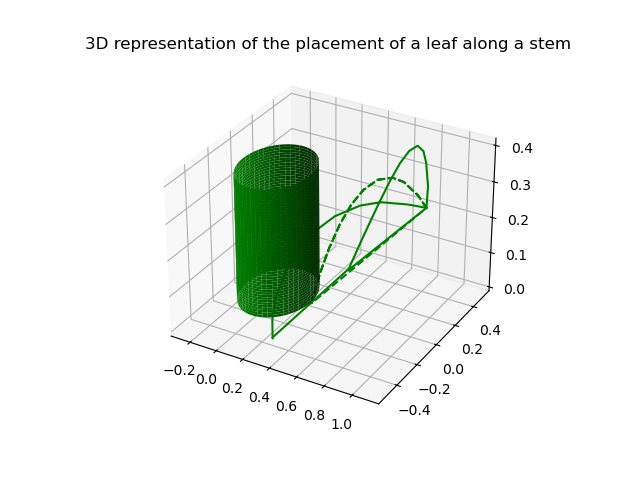

In [11]:
## Imports

# from installed packages
from math import pi, cos, sin, radians
import openalea.plantgl.all as pgl

# from ./src
# from cereals_leaf import arrange_leaf
# or 
from geometry import arrange_leaf

## Code for placing a leaf against a stem element (here a cylinder), with a given inclination
stem_diameter=0.5
inclination=1

al=arrange_leaf(leaf=pl, 
                stem_diameter=stem_diameter, 
                inclination=inclination, 
                relative=True)

x=al[0]
y=al[1]
s=al[2]
r=al[3]

pts,ind=leaf_to_mesh_2d(x, y, r)

xs=[pt[0] for pt in pts]
ys=[pt[1] for pt in pts]
zs=[pt[2] for pt in pts]
    
X,Y=np.meshgrid(xs, ys)

tri=mtri.Triangulation(xs, ys)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.plot(xs,ys,zs,c="green")
ax.plot([xs[0],xs[0]],[ys[0],-ys[0]],[0,0],c="green")
ax.plot(xs,np.zeros(len(ys)),zs,c="green",ls="dashed")

radius=stem_diameter/2
z=np.linspace(0, zs[-1])
theta=np.linspace(0, 2*np.pi)
theta_grid, z_stem=np.meshgrid(theta, z)
x_stem=radius*np.cos(theta_grid)
y_stem=radius*np.sin(theta_grid)

ax.plot_surface(x_stem, y_stem, z_stem, color="green")

ax.set_title("3D representation of the placement of a leaf along a stem")

plt.show()

## Build the whole plant shoot in 3D, as an MTG.

An MTG (Multiscale Tree Graph) is created as a representation of a parametrized cereal shoot.  
The different scales are: 
- Plant  
- Axis  
- Metamer  
- Stem / Leaf  
- StemElement / LeafElement  

In [12]:
## Imports

# from installed packages
import openalea.plantgl.all as pgl
from openalea.mtg.turtle import TurtleFrame
from openalea.mtg import MTG, fat_mtg
from scipy.interpolate import interp1d
import pandas

# from ./src
from geometry import slim_cylinder, stem_mesh, _is_iterable, as_tuples, addSets, leaf_mesh, compute_element, mtg_interpreter
# from cereals_leaf import leaf_mesh
from geometry import CerealsTurtle, CerealsVisitor
from fitting import leaf_element, leaf_to_mesh_2d, leaf_to_mesh, mesh4, plantgl_shape   # leaf_to_mesh_new ?
from plant_design import get_form_factor, blade_dimension, stem_dimension
from generator import majors_axes_regression, line_projection, as_leaf, as_plant, cereals as cereals_generator
# not neccessary to import, but useful to see which functions are used 


def build_shoot(stem_radius, insertion_heights, leaf_lengths, leaf_areas, leaf_azimuths=None, leaf_shapes=None):
    """create a shoot

    Args:
        stem_radius: (float) the stem radius
        insertion_heights: list of each leaf insertion height
        leaf_lengths: list of each leaf length (blade length)
        leaf_areas: list of each blade area
        collar_visible: list of each collar height or True if the collar is visible and False if it is not
        leaf_shapes: list of each leaf shape, if it is not known write None
        leaf_azimuths: list of each leaf azimuth, if it is not known write None

    Returns:
        shoot: 

    """
    ranks = range(1, len(leaf_lengths) + 1)
    ntop = max(ranks) - np.array(ranks) + 1
    if leaf_shapes is None:
        a_leaf = parametric_leaf()
        leaf_shapes = [a_leaf for r in ranks]
    if leaf_azimuths is None:
        leaf_azimuths = leaf_azimuth(len(ranks))
    leaf_azimuths[1:] = np.diff(leaf_azimuths)
    ff = [get_form_factor(leaf) for leaf in leaf_shapes]
    blades = blade_dimension(area=leaf_areas, length=leaf_lengths, ntop=ntop)
    stem = stem_dimension(h_ins=insertion_heights, d_internode=np.array(stem_radius) * 2, ntop=ntop)
    df = blades.merge(stem)
    df['leaf_azimuth'] = leaf_azimuths
    df['leaf_rank'] = ranks
    df['leaf_shape'] = [leaf_shapes[n - 1] for n in df.leaf_rank]
    return df, cereals_generator(plant=df)

In [13]:
# see problems with this function
def build_shoot_w_pseudo(nb_phy, plant_height, insertion_heights, leaf_lengths, leaf_areas, 
                pseudostem_dist=1.4, stem_dist=1.2,
                diam_base=2.5, diam_top=1, pseudostem_height=20, 
                leaf_azimuths=None, leaf_shapes=None, wl=0.1):
    """create a shoot, with pseudostems and stems

    Args:
        stem_radius: (float) the stem radius
        insertion_heights: list of each leaf insertion height
        leaf_lengths: list of each leaf length (blade length)
        leaf_areas: list of each blade area
        collar_visible: list of each collar height or True if the collar is visible and False if it is not
        leaf_shapes: list of each leaf shape, if it is not known write None
        leaf_azimuths: list of each leaf azimuth, if it is not known write None

    Returns:
        shoot: 

    """
    ranks = range(1, len(leaf_lengths) + 1)
    ntop = max(ranks) - np.array(ranks) + 1

    nb_phy = int(nb_phy)

    # Lejeune an Bernier formula + col =
    nb_young_phy = int(round((nb_phy - 1.95) / 1.84 / 1.3))

    # distances between leaves
    pseudostem = geometric_dist(pseudostem_height, nb_young_phy,
                                pseudostem_dist)
    stem = geometric_dist(plant_height - pseudostem_height,
                          nb_phy - nb_young_phy, stem_dist)
    internode = pseudostem + stem
    # stem diameters
    diameter = ([diam_base] * nb_young_phy +
                np.linspace(diam_base, diam_top,
                            nb_phy - nb_young_phy).tolist())
    
    if leaf_shapes is None:
        a_leaf = parametric_leaf()
        leaf_shapes = [a_leaf for r in ranks]
    if leaf_azimuths is None:
        leaf_azimuths = leaf_azimuth(len(ranks))
    leaf_azimuths[1:] = np.diff(leaf_azimuths)
    ff = [get_form_factor(leaf) for leaf in leaf_shapes]
    # blades = blade_dimension(area=leaf_areas, length=leaf_lengths, ntop=ntop)
    blades = blade_dimension(length=leaf_lengths, form_factor=ff, ntop=ntop, wl=wl)
    # stem = stem_dimension(h_ins=insertion_heights, d_internode=diameter, ntop=ntop)
    stem = stem_dimension(internode=internode, d_internode=diameter, ntop=ntop)
    
    df = blades.merge(stem)
    df['leaf_azimuth'] = leaf_azimuths
    df['leaf_rank'] = ranks
    df['leaf_shape'] = [leaf_shapes[n - 1] for n in df.leaf_rank]
    return df, cereals_generator(plant=df)

# shoot, g = build_shoot(3.0, [2,4,6,8], [2,4,6,8], [2,4,6,8])
# scene, nump = build_scene(g)
# display_scene(scene)

## Display scenes according to different scenarii

In [14]:
## Imports

# from installed packages
from oawidgets.plantgl import *

# Set nice color for plants
nice_green=Color3((50,100,0))

### A single cereal

In [15]:
## Imports

# from installed packages
from oawidgets.plantgl import *

# from ./src
from display import display_mtg, build_scene, display_scene

# Enable plotting with PlantGL
%gui qt

## Code for generating a 3D cereal shoot from descritive parameters
# Parameters 
stem_radius=1 
height=1500                 # from crop model
nb_phy=15                   # fixed max nb of phytomers
max_leaf_length=70 
insertion_angle=40
scurv=0.7
curvature=80
phyllotactic_angle=120
spiral=True

# Functions calls
insertion_heights=np.array(geometric_dist(height, 
                                          nb_phy, 
                                          q=1.2)) # further separate stem and pseudo stem, cf simple maize

leaf_lengths=np.array(bell_shaped_dist(max_leaf_length=max_leaf_length, 
                                       nb_phy=nb_phy, 
                                       rmax=0.7, 
                                       skew=0.15)) # plant area --> max leaf length
# leaf_areas=bell_shaped_dist(plant_area=1, nb_phy=15, rmax=0.7, skew=0.15) # cf blade_dimension

a_leaf = parametric_leaf(nb_segment=10, 
                         insertion_angle=insertion_angle, 
                         scurv=scurv, 
                         curvature=curvature, 
                         alpha=-2.3)

leaf_shapes = [a_leaf for l in leaf_lengths] # possible to replace leaf_length by nb_phy or...

leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), 
                             phyllotactic_angle=phyllotactic_angle, 
                             phyllotactic_deviation=15, 
                             plant_orientation=0, 
                             spiral=spiral)

shoot, g_single = build_shoot(stem_radius=stem_radius, 
                              insertion_heights=insertion_heights, 
                              leaf_lengths=leaf_lengths, 
                              leaf_areas=None, 
                              leaf_shapes=leaf_shapes, 
                              leaf_azimuths=leaf_azimuths)

# Build and display scene
scene_single, nump = build_scene(g_single, 
                                 leaf_material=Material(nice_green), 
                                 stem_material=Material(nice_green))
# display_scene(scene_single) # display in separate window
PlantGL(scene_single) # display in notebook

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

Let's dig into the propreties of the MTG of a cereal shoot.

['edge_type', 'label', 'length', 'is_green', 'diameter_base', 'diameter_top', 'azimuth', 'shape', 'shape_mature_length', 'visible_length', 'srb', 'srt', 'lrolled', 'd_rolled', 'shape_max_width', 'stem_diameter', 'geometry', 'anchor_point', 'color']


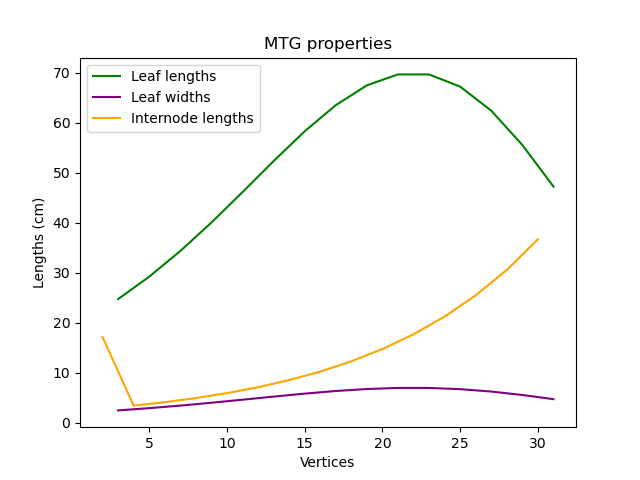

In [16]:
## Imports

# from installed packages
from oawidgets.mtg import *


## Code for exploring the MTG of the generated cereal shoot

# Properties on the MTG: this exclude all the topological properties
print(g_single.property_names())

# Retrieve one property for the MTG (dict)

labels = g_single.property('label')
# print(labels)

length = g_single.property('length')
# print(length)

leaf_lengths=[]
leaf_ind=[]
internode_lengths=[]
internode_ind=[]
for k,v in length.items():
    if k%2==0: # could have done it using labels
        internode_ind.append(k)
        internode_lengths.append(v)
    else:
        leaf_ind.append(k)
        leaf_lengths.append(v)

width = g_single.property('shape_max_width')
# print(width)

leaf_widths=[]
for k,v in width.items():
    leaf_widths.append(v)


plt.figure()
plt.plot(leaf_ind, leaf_lengths, c="green", label="Leaf lengths") # == 'shape_mature_length' for final plant
plt.plot(leaf_ind, leaf_widths, c="purple", label="Leaf widths")
plt.plot(internode_ind, internode_lengths, c="orange", label="Internode lengths")
plt.xlabel("Vertices")
plt.ylabel("Lengths (cm)")
plt.title("MTG properties")
plt.legend()
plt.show()

The leaf lengths and widths follow the bell shaped curve described before.  
The first internode in the MTG actually corresponds to the pseudostem, i.e. the about 4 to 8 short first internodes that rapidly lose their leaves. The lengths following internodes follow the geometric model described before.

In [17]:
#| echo: false

# classes = list(set(g.class_name(vid) for vid in g.vertices() if g.class_name(vid)))
# print(classes)

# def vertices(g, class_name='P'):
#     return [vid for vid in g.vertices() if g.class_name(vid)==class_name]

# vids_U = vertices(g, 'U')

# plot(g_single, selection=vids_U)

# plot(g_single, selection=[vid for vid in g_single.vertices() if g_single.class_name(vid)=='LeafElement'])

### A cereal crop with variability

In [18]:
## Imports

# from installed packages
from random import *

# from ./src
from stand import agronomic_plot

# Enable plotting with PlantGL
%gui qt

## Code for generating a random cereal crop from descritive parameters with variability 
# Fix a seed
seed(1)

# Initialize the list of plants
plants_in_crop=[]

# Fixed parameters for all plants
length_plot=5
width_plot=5
sowing_density=10
plant_density=10
inter_row=0.5
nplants, positions, domain, domain_area, unit = agronomic_plot(length_plot, 
                                                               width_plot, 
                                                               sowing_density, 
                                                               plant_density, 
                                                               inter_row, 
                                                               noise=0.1)

# For loop over all the plants in the crop
for n in range(nplants):
    # Parameters varying among plants
    stem_radius=1 
    height=1000*(1+random()-0.5) 
    nb_phy=15 
    max_leaf_length=50*(1+random()-0.5)
    insertion_angle=40*(1+random()-0.5)
    scurv=0.7*(1+random()-0.5)
    curvature=70*(1+random()-0.5)
    phyllotactic_angle=137*(1+random()-0.5)
    spiral=True

    # Functions calls
    insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2)) 
    leaf_lengths=np.array(bell_shaped_dist(max_leaf_length=max_leaf_length, nb_phy=nb_phy, rmax=0.7, skew=0.15)) 
    a_leaf = parametric_leaf(nb_segment=10, insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, alpha=-2.3)
    leaf_shapes = [a_leaf for l in leaf_lengths]
    leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), phyllotactic_angle=phyllotactic_angle, phyllotactic_deviation=15, 
                                 plant_orientation=random()*360, spiral=spiral)
    shoot, g_var = build_shoot(stem_radius=stem_radius, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, 
                               leaf_areas=None, leaf_shapes=leaf_shapes, leaf_azimuths=leaf_azimuths)

    # Fill the list of plants
    plants_in_crop.append(g_var)

# Build and display scene
scene_var, nump = build_scene(plants_in_crop, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
# display_scene(scene_var)
PlantGL(scene_var)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

### A seemingly growing plant

In [19]:
## Inputs

# from installed packages
from openalea.plantgl.all import *

# Enable plotting with PlantGL
%gui qt

## Code for generating a "growing" cereal shoot from descritive parameters
# Fix a seed
seed(1)

# Initialize the list of plant MTGs at different stages
growing_plants=[]

# Parameters fixing final plant or unchanged with "growth"
nplants=10
positions=[(x,0,0) for x in range(-500, 500, 100)]
final_height=1000
final_nb_phy=2*nplants
heights=geometric_dist(final_height, final_nb_phy, 1.2)
# insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2))
stem_radius=2 
insertion_angle=30
scurv=0.7
curvature=100
phyllotactic_angle=137
spiral=True

# For loop for generating plants at different stages
for n in range(1,nplants+1):
    # Parameters varying when "growing"
    height=10*heights[2*n-1]
    nb_phy=2*n 
    max_leaf_length=5*2*n
    
    # Functions calls
    insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2)) 
    leaf_lengths=np.array(bell_shaped_dist(max_leaf_length=max_leaf_length, nb_phy=nb_phy, rmax=0.7, skew=0.15)) 
    a_leaf = parametric_leaf(nb_segment=10, insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, alpha=-2.3)
    leaf_shapes = [a_leaf for l in leaf_lengths] 
    leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), phyllotactic_angle=phyllotactic_angle, 
                                 phyllotactic_deviation=15, plant_orientation=0, spiral=spiral)
    shoot, g_grow = build_shoot(stem_radius=stem_radius, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, 
                                leaf_areas=None, leaf_shapes=leaf_shapes, leaf_azimuths=leaf_azimuths)

    # Fill the list with MTG of "growing" plant
    growing_plants.append(g_grow)

# Build and display scene
scene_grow, nump = build_scene(growing_plants[2:], positions[2:], leaf_material=Material(nice_green), stem_material=Material(nice_green))
# display_scene(scene_grow)
PlantGL(scene_grow)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

### An intercrop organized in rows

In [20]:
## Inputs

# from installed packages
from openalea.plantgl.all import Material, Color3, Shape, Scene, Viewer, Translated, AxisRotated

# Enable plotting with PlantGL
%gui qt

## Code for generating an intercrop from descritive parameters

# Fix a seed
seed(1)

def plant(height, nb_phy, max_leaf_length, phyllotactic_angle, spiral):
    """ return the MTG of a cereal shoot generative from descriptive parameters """
    stem_radius=1 
    insertion_angle=30
    scurv=0.7
    curvature=100
    
    insertion_heights=np.array(geometric_dist(height, nb_phy, q=1.2)) 
    leaf_lengths=np.array(bell_shaped_dist(max_leaf_length=max_leaf_length, nb_phy=nb_phy, rmax=0.7, skew=0.15)) 
    a_leaf = parametric_leaf(nb_segment=10, insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, alpha=-2.3)
    leaf_shapes = [a_leaf for l in leaf_lengths] 
    leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), phyllotactic_angle=phyllotactic_angle, 
                                 phyllotactic_deviation=15, plant_orientation=random()*360, spiral=spiral)
    shoot, g = build_shoot(stem_radius=stem_radius, insertion_heights=insertion_heights, leaf_lengths=leaf_lengths, 
                           leaf_areas=None, leaf_shapes=leaf_shapes, leaf_azimuths=leaf_azimuths)
    
    return g


# Organize the plant mixture in alternate rows
n_rows = 10
len_rows = 10

d_inter = 70
d_intra = 50

def plant_in_row(i):
     if i%(4*d_inter)==0 or i%(4*d_inter)==d_inter: return plant(height=1700, nb_phy=15, max_leaf_length=100, phyllotactic_angle=137, spiral=True)
     else: return plant(height=900, nb_phy=20, max_leaf_length=40, phyllotactic_angle=60, spiral=True)


plants_in_intercrop = [plant_in_row(x) for x in range(0, n_rows*d_inter, d_inter) for y in range(0, len_rows*d_intra, d_intra)]

positions=[(x,y,0) for x in range(0, n_rows*d_inter, d_inter) for y in range(0, len_rows*d_intra, d_intra)]

# Build and display scene
scene_ic, nump = build_scene(plants_in_intercrop, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
# display_scene(scene_ic)
PlantGL(scene_ic)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## Tillering / Branching

In progress ...  

First, basipetal tillers, straight, oriented according to a certain angle, appearing according to a certain timing

In [21]:
#| echo: false

# Copy MTG single plant
g_branch = g_single.sub_mtg(g_single.root)

# g_branch.display()

# REARRANGE MTG WITH SCALES: PLANT, AXE, METAMER (with internode and leaf), ELEMENTS (StemElements and LeafElements)

In [22]:
#| echo: false

# Add branch 

from openalea.mtg import MTG

g = MTG()

plant_id = g.add_component(g.root, label='P1')

# scale 1
v1 = g.add_child(plant_id, label='A1')
v2 = g.add_child(plant_id, label='A2')
v3 = g.add_child(plant_id, label='A3')
v4 = g.add_child(v1, label='I1')
v5 = g.add_child(v1, label='I2')

# g.display()

from oawidgets.mtg import *
# plot(g)

## Leaf senescence

In progress ...  

Rate of senescence ? Constant number of leaves on a stem from a certain point or not ?

## Light interception with Caribu

In progress ...  

We have to configure Caribu to simulate the same light as in STICS

In [23]:
# #| echo: false

# ## Imports 
# from alinea.caribu.CaribuScene import CaribuScene
# from alinea.caribu.data_samples import data_path

# ## Code for computing light interception with Caribu
# sky = str(data_path('Turtle16soc.light'))
# # opts = map(str, [data_path('par.opt'), data_path('nir.opt')])

# # complete set of files
# cs = CaribuScene(scene=scene_var, light=sky) # opt=opts, ) #pattern=pattern)
# raw,agg=cs.run(simplify=True)

# # print(raw.keys())

# scene,values = cs.plot(raw['Ei'],display=False)

# v99 = np.percentile(values, 99)
# nvalues=np.array(values)
# nvalues[nvalues>v99]=v99
# values = nvalues.tolist()

# # PlantGL(scene, group_by_color=False, property=values)

In [24]:
# ## Code for computing light interception with Caribu
# sky = str(data_path('Turtle16soc.light'))
# # opts = map(str, [data_path('par.opt'), data_path('nir.opt')])

# # complete set of files
# cs = CaribuScene(scene=scene_ic, light=sky) # opt=opts, ) #pattern=pattern)
# raw,agg=cs.run(simplify=True)

# scene,values = cs.plot(raw['Ei'],display=False)

# v99 = np.percentile(values, 99)
# nvalues=np.array(values)
# nvalues[nvalues>v99]=v99
# values = nvalues.tolist()

# PlantGL(scene, group_by_color=False, property=values)

## Next steps

- Adapt for different species (parameters for cereals, some functions for legumes)

In [25]:
g_single.display()

MTG : nb_vertices=32, nb_scales=3
/plant			(id=1)											
^/StemElement			(id=2)											
	+LeafElement			(id=3)										
^<StemElement			(id=4)											
	+LeafElement			(id=5)										
^<StemElement			(id=6)											
	+LeafElement			(id=7)										
^<StemElement			(id=8)											
	+LeafElement			(id=9)										
^<StemElement			(id=10)											
	+LeafElement			(id=11)										
^<StemElement			(id=12)											
	+LeafElement			(id=13)										
^<StemElement			(id=14)											
	+LeafElement			(id=15)										
^<StemElement			(id=16)											
	+LeafElement			(id=17)										
^<StemElement			(id=18)											
	+LeafElement			(id=19)										
^<StemElement			(id=20)											
	+LeafElement			(id=21)										
^<StemElement			(id=22)											
	+LeafElement			(id=23)										
^<StemElement			(id=24)											
	+LeafElement			(id=25)										
^<StemElement			(id=26)											
	+LeafElement			(id=27)										
^<StemElement			(id=28)											
	+LeafElement		

In [26]:
from openalea.mtg.traversal import pre_order2
def thermal_time(g, phyllochron=110., leaf_duration=1.6, stem_duration=1.6, leaf_falling_rate = 10):
    """
    Add dynamic properties on the mtg to simulate developpement
    leaf_duration is the phyllochronic time for a leaf to develop from tip appearance to collar appearance
    stem_duration is the phyllochronic time for a stem to develop
    falling_rate (degrees / phyllochron) is the rate at which leaves fall after colar appearance
    """

    plants = g.vertices(scale=1)
    metamer_scale = g.max_scale()

    for plant in plants:
        tt = 0
        v = next(g.component_roots_at_scale_iter(plant, scale=metamer_scale))
        stem_ids = g.Trunk(v)
        nb_stems = len(stem_ids)
        nb_sectors = 1
        dtt = phyllochron*stem_duration
        
        for metamer in pre_order2(g, v):
            end_leaf = tt + phyllochron*leaf_duration
            nm = g.node(metamer)

            if 'Stem' in nm.label:
                stem_tt = tt
                nm.start_tt = stem_tt
                nm.end_tt = stem_tt+dtt
            else: # Leaf Element
                nm.start_tt = tt
                nm.end_tt = end_leaf
                tt += phyllochron

    return g

In [27]:
g=g_single.copy()

from oawidgets.mtg import plot as MTGw
# MTGw(g)

In [28]:
from dynamic import thermal_time

thermal_time(g)

In [29]:
g.properties()
plants = g.vertices(scale=1)
plant=1
metamer_scale=g.max_scale()
v = next(g.component_roots_at_scale_iter(plant, scale=metamer_scale))
print(list(pre_order2(g, v)))
# MTGw(g, properties=['start_tt','end_tt']) 

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [30]:
g.display()

MTG : nb_vertices=32, nb_scales=3
/plant			(id=1)											
^/StemElement			(id=2)											
	+LeafElement			(id=3)										
^<StemElement			(id=4)											
	+LeafElement			(id=5)										
^<StemElement			(id=6)											
	+LeafElement			(id=7)										
^<StemElement			(id=8)											
	+LeafElement			(id=9)										
^<StemElement			(id=10)											
	+LeafElement			(id=11)										
^<StemElement			(id=12)											
	+LeafElement			(id=13)										
^<StemElement			(id=14)											
	+LeafElement			(id=15)										
^<StemElement			(id=16)											
	+LeafElement			(id=17)										
^<StemElement			(id=18)											
	+LeafElement			(id=19)										
^<StemElement			(id=20)											
	+LeafElement			(id=21)										
^<StemElement			(id=22)											
	+LeafElement			(id=23)										
^<StemElement			(id=24)											
	+LeafElement			(id=25)										
^<StemElement			(id=26)											
	+LeafElement			(id=27)										
^<StemElement			(id=28)											
	+LeafElement		

In [31]:
g.Trunk(2)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

In [32]:
g.node(2).label

'StemElement'

In [33]:
g.node(3).shape

(array([0.00634027, 0.06693716, 0.12601321, 0.17710481, 0.24849582,
        0.33409181, 0.43411926, 0.50961433, 0.5962277 , 0.68355511,
        0.76088377, 0.83712401]),
 array([-0.00346833,  0.0859332 ,  0.15575262,  0.20645505,  0.26519042,
         0.31943549,  0.3622023 ,  0.3799512 ,  0.38430736,  0.37000106,
         0.3398266 ,  0.29160093]),
 array([0.        , 0.10800285, 0.19946175, 0.27144153, 0.36388892,
        0.46522599, 0.57401243, 0.65156583, 0.73828868, 0.82678018,
        0.90978753, 1.        ]),
 array([0.73783224, 0.88135009, 0.96283256, 0.99638426, 1.00152079,
        0.96548102, 0.88349353, 0.79021341, 0.64117414, 0.45187775,
        0.2610025 , 0.        ]))

In [34]:
from ipywidgets import interact, interactive, IntSlider, fixed
from dynamic import mtg_turtle_time

def grow_plant(time, g=g):
    #tm = 2000
    tt=time
    g = mtg_turtle_time(g, time=time)
    # Build and display scene
    scene, nump = build_scene(g, 
                              leaf_material=Material(nice_green), 
                              stem_material=Material(nice_green))
    w=PlantGL(scene, group_by_color=True)
    w.wireframe=True
    return w


In [35]:
w=grow_plant(100)
w.wireframe=True

In [36]:
max_time = max(g.property('end_tt').values())
interact(grow_plant, time=IntSlider(min=20, max=max_time+1, step=100, value=1000), g=fixed(g))

interactive(children=(IntSlider(value=1000, description='time', max=1717, min=20, step=100), Output()), _dom_c…

<function __main__.grow_plant(time, g=<openalea.mtg.mtg.MTG object at 0x0000024C1BB21E80>)>

In [37]:
## Code for generating a "growing" cereal shoot from descritive parameters
# Fix a seed
seed(1)

# Initialize the list of plant MTGs at different stages
growing_plants=[]
positions=[(x,0,0) for x in range(0, 700, 70)]

# For loop for generating plants at different stages
for time in range(0,1500,150):
    gg=mtg_turtle_time(g, time=time).sub_mtg(mtg_turtle_time(g, time=time).root) 
    # Fill the list with MTG of "growing" plant
    growing_plants.append(gg)

# Build and display scene
scene_grow, nump = build_scene(growing_plants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
# display_scene(scene_grow)
PlantGL(scene_grow)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [41]:
for i in range(0,30):
    if growing_plants[5].node(i).visible_length is not None and growing_plants[5].node(i).length != 0:
        print(growing_plants[5].node(i).label, growing_plants[5].node(i).visible_length)

LeafElement 1.5100143003786344
LeafElement 7.1004667902274505
LeafElement 18.623163278158977
LeafElement 0.12312977265169035
LeafElement 4.226245055720833
LeafElement 15.251406915754622
LeafElement 63.553536820573996
LeafElement 46.03756575583349
LeafElement 3.9608188394105213
LeafElement 69.70061603858217
LeafElement 67.26605475234291
LeafElement 62.44690804395808
LeafElement 55.57978214425167


In [39]:
growing_plants[5].node(13).shape

(array([0.00634027, 0.06693716, 0.12601321, 0.17710481, 0.24849582,
        0.33409181, 0.43411926, 0.50961433, 0.5962277 , 0.68355511,
        0.76088377, 0.83712401]),
 array([-0.00346833,  0.0859332 ,  0.15575262,  0.20645505,  0.26519042,
         0.31943549,  0.3622023 ,  0.3799512 ,  0.38430736,  0.37000106,
         0.3398266 ,  0.29160093]),
 array([0.        , 0.10800285, 0.19946175, 0.27144153, 0.36388892,
        0.46522599, 0.57401243, 0.65156583, 0.73828868, 0.82678018,
        0.90978753, 1.        ]),
 array([0.73783224, 0.88135009, 0.96283256, 0.99638426, 1.00152079,
        0.96548102, 0.88349353, 0.79021341, 0.64117414, 0.45187775,
        0.2610025 , 0.        ]))

In [40]:
growing_plants[5].node(13).srt

1

Problems encountered:  
- insertion point of leaves in stem should move as internode grows (translation of leaf shape downwards)
- leaf shape should be modified so that (s,r) is taken from the tip (ok with srb set at 1 - %growth), but (x,y) is taken from base